# Looking into Bezier curves

Want to use Bezier curves to generate smooth, continuous trajectories to explore the latent space. First came across [this Medium article](https://towardsdatascience.com/b%C3%A9zier-curve-bfffdadea212) by Omar Aflak that explains how to program these curves, and later found out about the [bezier](https://github.com/dhermes/bezier) library. Gonna try out both.

### Medium article

This is for representing Bezier curves in matrix form. Originally from https://gist.githubusercontent.com/OmarAflak/860ef23fcdd57dfd83470381f5db9b31/raw/367163e81eabdfdbfa26e3e4cc06ac85b54c7cf0/medium_bezier_matrix.py

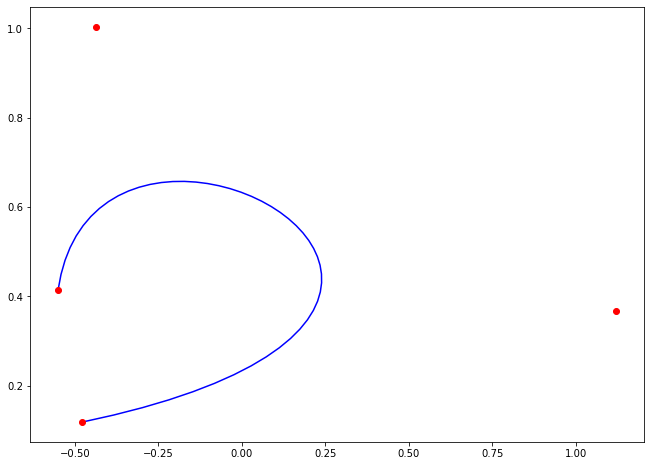

In [3]:
from math import factorial
import numpy as np
import matplotlib.pyplot as plt

def comb(n, k):
    return factorial(n) //  (factorial(k) * factorial(n - k))

def get_bezier_matrix(n):
    coef = [[comb(n, i) * comb(i, k) * (-1)**(i - k) for k in range(i + 1)] for i in range(n + 1)]
    # padding with zeros to create a square matrix
    return [row + [0] * (n + 1 - len(row)) for row in coef]

def evaluate_bezier(points, total):
    n = len(points) - 1
    T = lambda t: [t**i for i in range(n + 1)]
    M = get_bezier_matrix(n)
    return np.array([
        np.dot(np.dot(T(t), M), points)
        for t in np.linspace(0, 1, 50)
    ])

points = np.random.randn(4, 2)
x, y = points[:,0], points[:,1]

new_points = evaluate_bezier(points, 50)
nx, ny = new_points[:,0], new_points[:,1]

plt.figure(figsize=(11, 8))
plt.plot(nx, ny, 'b-')
plt.plot(x, y, 'ro')
plt.show()

This is for not using the matrix notation. Originally from https://gist.githubusercontent.com/OmarAflak/06625f06bc1dbddecda908bfb3eb2970/raw/ef86cc25e13ab2b3f56c5e1f2b0e98ce916d1750/medium_bezier.py

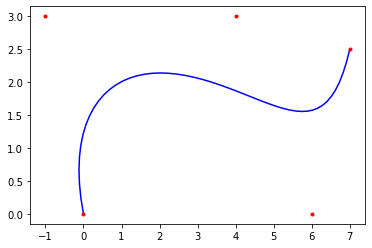

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial

def comb(n, k):
    return factorial(n) // (factorial(k) * factorial(n - k))

def get_bezier_curve(points):
    n = len(points) - 1
    return lambda t: sum(
        comb(n, i) * t**i * (1 - t)**(n - i) * points[i]
        for i in range(n + 1)
    )

def evaluate_bezier(points, total):
    bezier = get_bezier_curve(points)
    new_points = np.array([bezier(t) for t in np.linspace(0, 1, total)])
    return new_points[:,0], new_points[:,1]

points = np.array([
    [0, 0],
    [-1, 3],
    [4, 3],
    [6, 0],
    [7, 2.5]
])

x, y = points[:,0], points[:,1]
bx, by = evaluate_bezier(points, 50)
plt.plot(bx, by, 'b-')
plt.plot(x, y, 'r.')
plt.show()

From my understanding, they are fundamentally the same code. Gonna test this out.

In [10]:
def comb(n: int, k: int):
    return factorial(n) // (factorial(k) * factorial(n - k))

def get_bezier_curve(points):
    n = len(points) - 1
    return lambda t: sum(
        comb(n, i) * t**i * (1 - t)**(n - i) * points[i]
        for i in range(n + 1)
    )

def evaluate_bezier_curve(points, total):
    bezier = get_bezier_curve(points)
    new_points = np.array([bezier(t) for t in np.linspace(0, 1, total)])
    return new_points[:,0], new_points[:,1]

def get_bezier_mat(n):
    coef = [[comb(n, i) * comb(i, k) * (-1)**(i - k) for k in range(i + 1)] for i in range(n + 1)]
    # padding with zeros to create a square matrix
    return [row + [0] * (n + 1 - len(row)) for row in coef]

def evaluate_bezier_mat(points, total):
    n = len(points) - 1
    T = lambda t: [t**i for i in range(n + 1)]
    M = get_bezier_matrix(n)
    return np.array([
        np.dot(np.dot(T(t), M), points)
        for t in np.linspace(0, 1, 50)
    ])

In [28]:
def bezier_curve(ctrl_points, num_points):
    nx_curve, ny_curve = evaluate_bezier_curve(ctrl_points, num_points)
    return nx_curve, ny_curve

In [29]:
def bezier_mat(ctrl_points, num_points):
    new_points_mat = evaluate_bezier_mat(ctrl_points, num_points)
    nx_mat, ny_mat = new_points_mat[:,0], new_points_mat[:,1]
    return nx_mat, ny_mat

In [13]:
n = 5
points = np.random.standard_normal((n, 2))
x, y = points[:, 0], points[:, 1]

In [14]:
new_points_mat = evaluate_bezier_mat(points, 50)
nx_mat, ny_mat = new_points_mat[:,0], new_points_mat[:,1]
nx_curve, ny_curve = evaluate_bezier_curve(points, 50)

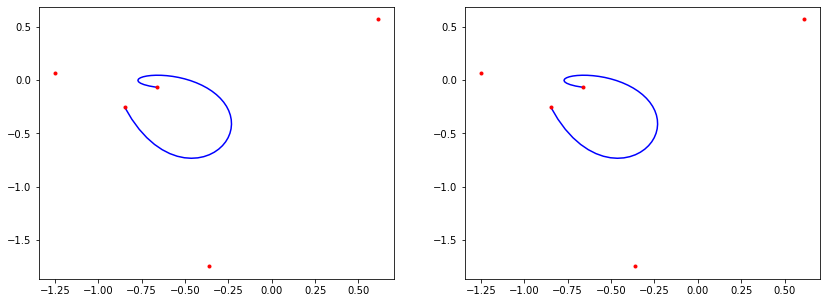

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 5))

ax[0].plot(nx_mat, ny_mat, 'b-')
ax[0].plot(x, y, 'r.')

ax[1].plot(nx_curve, ny_curve, 'b-')
ax[1].plot(x, y, 'r.')
plt.show()

Yup! Totally the same.

In [30]:
%%timeit
bezier_curve(points, 50)

2.2 ms ± 86.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
%%timeit
bezier_mat(points, 50)

1.33 ms ± 43.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


I also like numpy more, thanks for validating my personal bias.

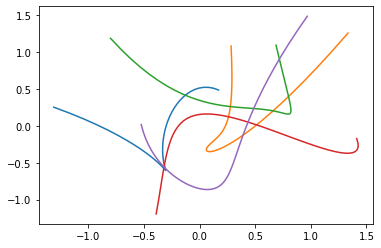

In [33]:
for _ in range(5):
    nx, ny = bezier_mat(np.random.standard_normal(size=(5, 2)), 50)
    plt.plot(nx, ny)
plt.show()

Okay. I think this is good enough, no need to look into the bezier library. 

Now, how do I ensure that the slope of the curve at the end can be matched by a slope from a new curve?

### Tangents

Quick read on this pointed to the fact that Bezier curves are tangent to the line segments that make up the opening and closing segment. Thus point generation just needs to ensure the first line segment has the same slope as the last line segment.

In [57]:
np.random.uniform(low=0.1, high=0.5)

0.3642610786460111

In [178]:
def gen_ctrl_points(num_ctrl_points, prev_points=None):
    assert num_ctrl_points > 2, "Continuation of slope needs >2 points to work"
    assert prev_points is None or isinstance(prev_points, np.ndarray)
    if isinstance(prev_points, np.ndarray):
        assert (len(prev_points.shape) == 2) and (prev_points.shape[1] == 2)
        
    if prev_points is None:
        return np.random.standard_normal(size=(num_ctrl_points, 2))
    else:
        end_slope_vec = prev_points[-1, :] - prev_points[-2, :]
        end_slope_uvec = end_slope_vec / np.linalg.norm(end_slope_vec)
        new_second_row = prev_points[-1, :] + end_slope_uvec * np.random.uniform(low=0.1, high=0.5)
        return np.concatenate([[prev_points[-1, :]], [new_second_row], np.random.standard_normal(size=(num_ctrl_points-2, 2))])

In [179]:
gen_ctrl_points(5, points)

array([[-0.66264388, -0.06788725],
       [-0.48843585, -0.10780996],
       [-0.52996116,  0.28377312],
       [-0.62698668,  0.99423934],
       [ 0.30193313, -0.47046674]])

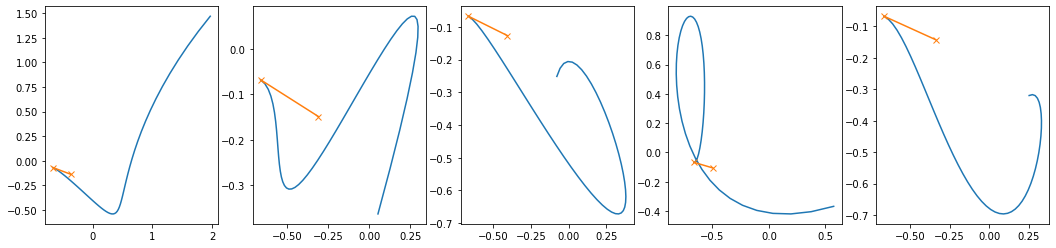

In [98]:
fig, ax = plt.subplots(
    ncols=5, figsize=(18, 4),
    # sharex=True, sharey=True
)
for i in range(5):
    new_ctrl_points = gen_ctrl_points(5, points)
    nx, ny = bezier_mat(new_ctrl_points, 50)
    ax[i].plot(nx, ny)
    ax[i].plot(new_ctrl_points[:2, 0], new_ctrl_points[:2, 1], marker="x")
plt.show()

Real test is to combine all of them together.

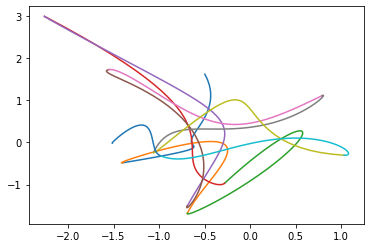

In [111]:
ctrl_points = gen_ctrl_points(5)
nx, ny = bezier_mat(ctrl_points, 50)
plt.plot(nx, ny)
for _ in range(10):
    ctrl_points = gen_ctrl_points(5, ctrl_points)
    nx, ny = bezier_mat(ctrl_points, 50)
    plt.plot(nx, ny)
plt.show()

Looks good to me. Limitations though is that this works in 2D space, but we'll see.

### Convert to equivalent format for use in code

For context, this is the current generator for sampling straight trajectories in latent space:

```
def _point2point_latent_explorer_generator(
        self,
        dims: int,
        min_coord: np.ndarray,
        max_coord: np.ndarray,
        init_coord: np.ndarray,
        stepsize: float,
        smooth_start_stop: bool,
    ) -> Generator[np.ndarray, None, None]:
        current_point = init_coord
        while True:
            # Find next point
            next_point = np.random.uniform(low=min_coord, high=max_coord, size=(dims,))

            # Calculate distance because we want to determine steps and direction
            dist = np.linalg.norm(next_point - current_point)
            stepcount = int(dist / stepsize)
            steps = np.linspace(current_point, next_point, stepcount)

            # Smooth decel and accel
            if smooth_start_stop is True:
                # Decel final 20% of path
                # 80% to 90% runs at 1.5x steps
                # 90% to 100% runs at 3x steps
                decel_point1 = int(stepcount * 0.8)
                decel_point2 = int(stepcount * 0.9)
                decel_path1 = np.linspace(
                    steps[decel_point1],
                    steps[decel_point2],
                    int(1.5 * (decel_point2 - decel_point1)),
                )
                decel_path2 = np.linspace(
                    steps[decel_point2], steps[-1], int(3 * (stepcount - decel_point2))
                )

                # Accel first 10% of path
                # 0% to 10% stretched into 3x steps
                # 10% to 20% stretched into 1.5x steps
                # Pretty much reverse of above
                accel_point1 = int(stepcount * 0.1)
                accel_point2 = int(stepcount * 0.2)
                accel_path1 = np.linspace(
                    steps[0], steps[accel_point1], int(3 * (accel_point1 - 0))
                )
                accel_path2 = np.linspace(
                    steps[accel_point1],
                    steps[accel_point2],
                    int(1.5 * (accel_point2 - accel_point1)),
                )

                steps = np.concatenate(
                    [
                        accel_path1,
                        accel_path2,
                        steps[accel_point2:decel_point1],
                        decel_path1,
                        decel_path2,
                    ]
                )
            else:
                pass

            for i in range(steps.shape[0]):
                yield steps[i, :]

            current_point = next_point
```

In [187]:
def test_ctrl_points_tangent_to_prev_ctrl_points():
    ctrl_points1 = gen_ctrl_points(num_ctrl_points=5, prev_points=None)
    ctrl_points2 = gen_ctrl_points(num_ctrl_points=5, prev_points=ctrl_points1)
    assert np.array_equal(ctrl_points1[-1, :], ctrl_points2[0, :]), f"{ctrl_points1[-1, :]}, {ctrl_points2[0, :]}"

In [188]:
test_ctrl_points_tangent_to_prev_ctrl_points()

In [274]:
def bezier_sampler(num_ctrl_points=5, steps=50):
    prev_ctrl_points = None
    while True:
        
        ctrl_points = gen_ctrl_points(num_ctrl_points, prev_ctrl_points)
        if prev_ctrl_points is not None:
            assert np.array_equal(ctrl_points[0, :], prev_ctrl_points[-1, :]), f"{ctrl_points[0, :]}, {prev_ctrl_points[-1, :]}"
        nx, ny = bezier_mat(ctrl_points, steps)
        
        for i in range(steps):
            yield np.array([nx[i], ny[i]])
            
        prev_ctrl_points = ctrl_points.copy()
        

Mmm. How do I test this?

In [275]:
sampler = bezier_sampler(5, 50)
nxs = []
nys = []

In [276]:
for i in range(50*5):
    x, y = next(sampler)
    nxs.append(x)
    nys.append(y)

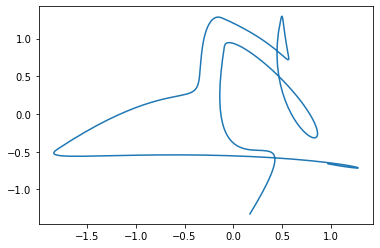

In [277]:
plt.plot(nxs, nys); plt.show()

0 49
50 99
100 149
150 199
200 249


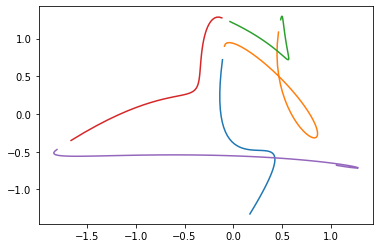

In [278]:
for i in range(5):
    start_idx = i*50
    end_idx = (i+1)*50-1
    print(start_idx, end_idx)
    
    plt.plot(nxs[start_idx:end_idx], nys[start_idx:end_idx])
plt.show()

Works.

In [279]:
class BezierSampler():
    def __init__(self, num_ctrl_points=5, steps=50):
        self.generator = bezier_sampler(num_ctrl_points, steps)
    
    def sample(self):
        return next(self.generator)

In [280]:
sampler = BezierSampler(5, 50)
nxs = []
nys = []

In [283]:
for i in range(250):
    x, y = sampler.sample()
    nxs.append(x)
    nys.append(y)

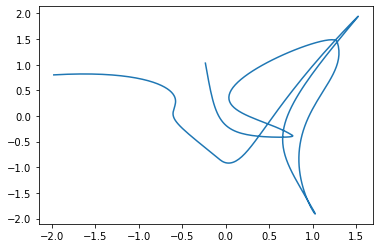

In [284]:
plt.plot(nxs, nys)